# Evaluate a single-modal CNN on the given test set 

Written by Xirong Li

2022-02-26

## Environment
+ Ubuntu 18.04.5 LTS
+ Python 3.7.12
+ conda install pytorch==1.1.0 torchvision==0.3.0 cudatoolkit=10.0 
+ See requirements.txt for other python packages

In [1]:
import os
os.chdir("../code/")

import time
import torch
import torchvision
import numpy as np
import cv2 as cv

import utils
import models
import data
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

# 1. Evaluate a CFP single-modal CNN

## Step 1. Load a trained CFP model

In [2]:
device = 0
device = torch.device("cuda: {}".format(device) if (torch.cuda.is_available() and device != "cpu") else "cpu")
configs = utils.load_config("config-cfp.py")
configs.heatmap = True

label_list = 'h d p w'.split() # normal, dryAMD, pcv and wetAMD
n_classes = len(label_list)
checkpoint = "weights/weights_splitA/cfp-clahe-1.pth"

model = models.load_single_stream_model(configs, device, checkpoint)
model.eval()
print ()

load checkpoint 'weights/weights_splitA/cfp-clahe-1.pth'



## Step 2. Load test image ids

In [3]:
testset = 'mmc-amd-splitA-test'
modality = 'cfp'
imset = data.read_imset(testset, modality)
n_samples = len(imset)
y_true = []
for test_img_id in imset:
    y = test_img_id.split('-')[1]
    y = label_list.index(y)
    y_true.append(y)
print ('%s, %s -> %d test samples' % (testset, modality, len(imset)))
print ("#label count")
for i,lab in enumerate(label_list):
    print (lab, y_true.count(i))

mmc-amd-splitA-test, cfp -> 80 test samples
#label count
h 20
d 20
p 20
w 20


### Step 2.1 Try to predict a specific image

In [4]:
test_img_id = imset[0]
impath = data.get_impath(test_img_id)
print(impath)
raw_im, new_im = data.load_image(impath, configs)
y = test_img_id.split('-')[1]
assert(y in label_list)
scores = models.predict(model, new_im.to(device))
pred = np.argmax(scores)
print (test_img_id, y, '->', scores, label_list[pred])

VisualSearch/mmc-amd/ImageData/cfp-clahe-448x448/f-w-1544817.jpg
f-w-1544817 w -> [0.02752941 0.36061063 0.2078416  0.40401834] w


## Step 3. Predict the test set

In [5]:
s_time = time.time()
score_table = np.zeros((n_samples, n_classes))
for i, test_img_id in enumerate(imset):
    impath = data.get_impath(test_img_id)
    raw_im, new_im = data.load_image(impath, configs)
    scores = models.predict(model, new_im.to(device))
    score_table[i] = scores
y_pred = np.argmax(score_table, axis=1)
timespan = time.time() - s_time
print ("process %d images in %g seconds" % (n_samples, timespan))

process 80 images in 0.993214 seconds


## Step 4. Report performance metrics

### Accuracy

In [6]:
accuracy = accuracy_score(y_true, y_pred)
print ('accuracy %.4f' % accuracy)

accuracy 0.7125


### Mutli-class Confusion matrix

In [7]:
confusion_matrix(y_true, y_pred)

array([[20,  0,  0,  0],
       [ 1, 15,  0,  4],
       [ 0,  2, 13,  5],
       [ 1,  3,  7,  9]])

### Sensitivity, Specificity and F1 per class

In [8]:
class_names = 'normal dryAMD pcv wetAMD'.split()
print ('#class sen spe f1')
oper_points = []
for i in range(n_classes):
    y_test = [int(x==i) for x in y_true] # obtain binary label per class
    tn, fp, fn, tp = confusion_matrix(y_test, [x==i for x in y_pred]).ravel()
    sen = float(tp) / (fn + tp)
    spe = float(tn) / (tn + fp)
    f1 = 2*sen*spe / (sen + spe)
    oper_points.append((1-spe, sen))
    print (class_names[i], '%.3f %.3f %.3f' % (sen, spe, f1))

#class sen spe f1
normal 1.000 0.967 0.983
dryAMD 0.750 0.917 0.825
pcv 0.650 0.883 0.749
wetAMD 0.450 0.850 0.588


### ROC curves and AUC

In [9]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    y_test = [int(x==i) for x in y_true] # obtain binary label per class
    y_score = score_table[:, i] # prediced scores per class
    fpr[i], tpr[i], _ = roc_curve(y_test, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

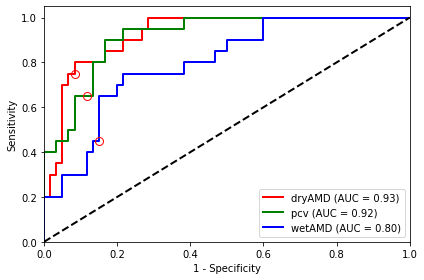

In [10]:
lw = 2
plt.figure()

colors = ["black", "red", "green", "blue"]
for i, color in zip(range(n_classes), colors):
    if i <1:
        continue
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="{0} (AUC = {1:0.2f})".format(class_names[i], roc_auc[i]),
    )
    plt.plot(oper_points[i][0], oper_points[i][1], 'o', 
         ms=8, markerfacecolor="None", markeredgecolor='red')

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# 2. Evaluate an OCT single-modal CNN

## Step 1. Load a trained OCT model

In [11]:
device = 0
device = torch.device("cuda: {}".format(device) if (torch.cuda.is_available() and device != "cpu") else "cpu")
configs = utils.load_config("config-oct.py")
configs.heatmap = True

label_list = 'h d p w'.split() # normal, dryAMD, pcv and wetAMD
n_classes = len(label_list)
checkpoint = "weights/weights_splitA/oct-median3x3-1.pth"

model = models.load_single_stream_model(configs, device, checkpoint)
model.eval()
print ()

load checkpoint 'weights/weights_splitA/oct-median3x3-1.pth'



## Step 2. Load test image ids

In [12]:
testset = 'mmc-amd-splitA-test'
modality = 'oct'
imset = data.read_imset(testset, modality)
n_samples = len(imset)
y_true = []
for test_img_id in imset:
    y = test_img_id.split('-')[1]
    y = label_list.index(y)
    y_true.append(y)
print ('%s, %s -> %d test samples' % (testset, modality, len(imset)))
print ("#label count")
for i,lab in enumerate(label_list):
    print (lab, y_true.count(i))

mmc-amd-splitA-test, oct -> 143 test samples
#label count
h 20
d 38
p 47
w 38


### Step 2.1 Try to predict a specific image

In [13]:
test_img_id = imset[0]
impath = data.get_impath(test_img_id)
print(impath)
raw_im, new_im = data.load_image(impath, configs)
y = test_img_id.split('-')[1]
assert(y in label_list)
scores = models.predict(model, new_im.to(device))
pred = np.argmax(scores)
print (test_img_id, y, '->', scores, label_list[pred])

VisualSearch/mmc-amd/ImageData/oct-median3x3-448x448/o-w-27662-l_003.jpg
o-w-27662-l_003 w -> [0.00460858 0.00433527 0.24710102 0.7439552 ] w


## Step 3. Predict the test set

In [14]:
s_time = time.time()
score_table = np.zeros((n_samples, n_classes))
for i, test_img_id in enumerate(imset):
    impath = data.get_impath(test_img_id)
    raw_im, new_im = data.load_image(impath, configs)
    scores = models.predict(model, new_im.to(device))
    score_table[i] = scores
y_pred = np.argmax(score_table, axis=1)
timespan = time.time() - s_time
print ("process %d images in %g seconds" % (n_samples, timespan))

process 143 images in 1.76993 seconds


## Step 4. Report performance metrics

### Accuracy

In [15]:
accuracy = accuracy_score(y_true, y_pred)
print ('accuracy %.4f' % accuracy)

accuracy 0.8252


### Mutli-class Confusion matrix

In [16]:
confusion_matrix(y_true, y_pred)

array([[20,  0,  0,  0],
       [ 1, 34,  1,  2],
       [ 0,  0, 36, 11],
       [ 0,  1,  9, 28]])

### Sensitivity, Specificity and F1 per class

In [17]:
class_names = 'normal dryAMD pcv wetAMD'.split()
print ('#class sen spe f1')
oper_points = []
for i in range(n_classes):
    y_test = [int(x==i) for x in y_true] # obtain binary label per class
    tn, fp, fn, tp = confusion_matrix(y_test, [x==i for x in y_pred]).ravel()
    sen = float(tp) / (fn + tp)
    spe = float(tn) / (tn + fp)
    f1 = 2*sen*spe / (sen + spe)
    oper_points.append((1-spe, sen))
    print (class_names[i], '%.3f %.3f %.3f' % (sen, spe, f1))

#class sen spe f1
normal 1.000 0.992 0.996
dryAMD 0.895 0.990 0.940
pcv 0.766 0.896 0.826
wetAMD 0.737 0.876 0.800


### ROC curves and AUC

In [18]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    y_test = [int(x==i) for x in y_true] # obtain binary label per class
    y_score = score_table[:, i] # prediced scores per class
    fpr[i], tpr[i], _ = roc_curve(y_test, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

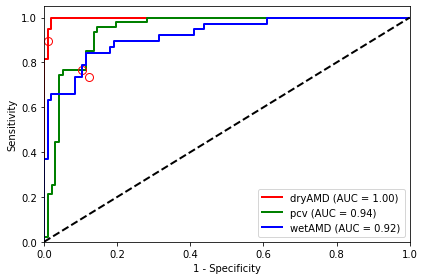

In [19]:
lw = 2
plt.figure()

colors = ["black", "red", "green", "blue"]
for i, color in zip(range(n_classes), colors):
    if i <1:
        continue
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="{0} (AUC = {1:0.2f})".format(class_names[i], roc_auc[i]),
    )
    plt.plot(oper_points[i][0], oper_points[i][1], 'o', 
         ms=8, markerfacecolor="None", markeredgecolor='red')

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()